# FlexLogger Python Automation Example

With the [FlexLogger Automation API](https://github.com/ni/niflexlogger-automation-python), users can control a FlexLogger test session and analyze the resulting data with the same Python program.

## Connect to FlexLogger and run a test

This example connects to an already-running FlexLogger project, so the **Automation server** preference must be enabled:

<img src="./images/app-preferences.png"/>

In [7]:
import time
from flexlogger.automation import Application

flexlogger_app = Application()
project = flexlogger_app.get_active_project()
if project is None:
       print("No project is open in FlexLogger!")
test_session = project.test_session
test_session.start()
time.sleep(30)  # time for operator to manipulate the DUT
test_session.stop()
flexlogger_app.disconnect()

## Read the resulting TDMS data file

There are several TDMS packages available on the Python Package Index ([PyPI](https://pypi.org/)). This example uses [npTDMS](https://pypi.org/project/npTDMS/) ([docs](https://nptdms.readthedocs.io/en/stable/index.html)) to access the test data as [NumPy](https://numpy.org/doc/stable/user/index.html) arrays. 

In [1]:
import nptdms
import os
import pathlib

data_directory = pathlib.Path(os.getcwd()) / "FlexLogger-Project" / "data"
data_files = data_directory.glob("*")
latest_file_path = max(data_files, key=lambda p: p.stat().st_ctime)
if latest_file_path.suffix == ".tdms_index":
    latest_file_path = latest_file_path.with_suffix(".tdms")
print("Analyzing new TDMS file: {}".format(latest_file_path))
tdms_file = nptdms.TdmsFile.read(latest_file_path)


Analyzing new TDMS file: c:\sandbox\flexlogger-automation-example\FlexLogger-Project\data\LogFile_2021-02-23-09-45-28.tdms


## Review the project's Test properties

FlexLogger allows users to [log custom test properties](https://www.ni.com/documentation/en/flexlogger/21.0/manual/adding-metadata-to-a-project/) to supplement the measurement data. The example project has three different properties:

<img src="./images/test-properties.png"/>

In [2]:
test_information = tdms_file["Test Information"]
test_DUT = test_information.properties["Test_properties~DUT"]
test_Location = test_information.properties["Test_properties~Location"]
test_Station = test_information.properties["Test_properties~Test Station"]
print(
    "DUT: {} ; Location: {} ; Test station: {}".format(
        test_DUT, test_Location, test_Station
    )
)

DUT: Rev3 ; Location: Austin ; Test station: PT-2


## Were the measurements within the expected bounds?

This example uses a FlexLogger project with a configured NI-9215 input module:

<img src="./images/9215-configured.png"/>

Check the bounds using NumPy's [min and max methods](https://numpy.org/doc/stable/reference/arrays.ndarray.html#array-methods).

In [3]:
channels = tdms_file["Log"].channels()
voltage_max = 7
voltage_min = 1
for channel in channels:
    channel_max = channel.data.max()
    channel_min = channel.data.min()
    within_bounds = (voltage_max > channel_max) and (channel_min > voltage_min)
    if within_bounds:
        print(
            "{} stayed within the expected voltage range".format(
                channel.name
            )
        )
    else:
         print(
             "{} went OUTSIDE the expected voltage range".format(
                 channel.name
             )
         )

Differential_Voltage_0 went OUTSIDE the expected voltage range
Differential_Voltage_1 stayed within the expected voltage range
Differential_Voltage_2 stayed within the expected voltage range
Differential_Voltage_3 stayed within the expected voltage range


## Visualize the measurements

Plot the measurement data with [Matplotlib](https://matplotlib.org/stable/index.html) - the most popular Python visualization library.

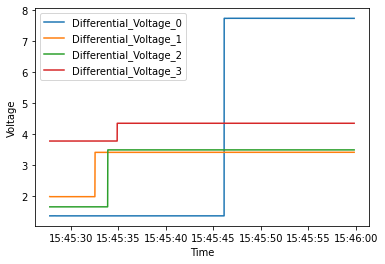

In [4]:
import matplotlib.pyplot as plt

channel_time = channels[0].time_track(absolute_time=True)
fig, ax = plt.subplots()
ax.set(
     xlabel="Time", ylabel="Voltage"
)  # channels from the same DAQ sample group share timing information

for channel in channels:
    ax.plot(channel_time, channel.data, label=channel.name)
ax.legend()
plt.show()